## Cài đặt các thư viện cần thiết

In [ ]:
# !pip install neattext
# !pip install wordcloud
# !pip install nltk

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud
import neattext.functions as nfx
import nltk
from nltk.corpus import stopwords
import re

import neattext as nt

## 1. Đọc dữ liệu 

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 2. Tìm hiểu dữ liệu

Tập dữ liệu bao gồm thông tin các bài luận được viết bởi sinh viên, được chấm điểm từ 1 -> 6.

- Dữ liệu train

Các hàng của dữ liệu

In [3]:
train_df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\r\n\r\nThis is a letter to...",3


Thông tin cơ bản về dữ liệu

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


- Dữ liệu test

Các hàng của dữ liệu

In [5]:
test_df.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


Thông tin cơ bản về dữ liệu

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   3 non-null      object
 1   full_text  3 non-null      object
dtypes: object(2)
memory usage: 176.0+ bytes


Ý nghĩa của các cột dữ liệu:
- `essay_id`: ID của bài luận.
- `full_text`: Nội dung bài luận.
- `score`: Điểm tổng thể của bài luận trong thang điểm từ 1 - 6.

Kích thước của dữ liệu

In [7]:
print('Kích thước của dữ liệu train:', train_df.shape)
print('Kích thước của dữ liệu test:', test_df.shape)


Kích thước của dữ liệu train: (17307, 3)
Kích thước của dữ liệu test: (3, 2)


## 3. Tiền xử lý dữ liệu

### Xử lý trùng lặp dữ liệu

In [8]:
# Dữ liệu train 
is_duplicated = np.any(train_df.duplicated())
if is_duplicated:
    print('Dữ liệu có trùng lặp')
else:
    print('Dữ liệu không trùng lặp')

Dữ liệu không trùng lặp


In [9]:
# Dữ liệu test 
is_duplicated = np.any(test_df.duplicated())
if is_duplicated:
    print('Dữ liệu có trùng lặp')
else:
    print('Dữ liệu không trùng lặp')

Dữ liệu không trùng lặp


Vậy dữ liệu không có trùng lặp.

### Kiểm tra Missing value

In [10]:
# Dữ liệu train
missing_percent = (train_df.isnull().sum() / len(train_df)) * 100
print(missing_percent)

essay_id     0.0
full_text    0.0
score        0.0
dtype: float64


In [11]:
# Dữ liệu test
missing_percent = (test_df.isnull().sum() / len(train_df)) * 100
print(missing_percent)

essay_id     0.0
full_text    0.0
dtype: float64


Vậy dữ liệu không có Missing vale.

#### Sau tiền xử lý thì dữ liệu không có gì thay đổi nên ta sẽ nguyên để dữ nguyên dữ liệu gốc để áp dụng Model

## 4. Khám phá dữ liệu

### Phân phối điểm số 

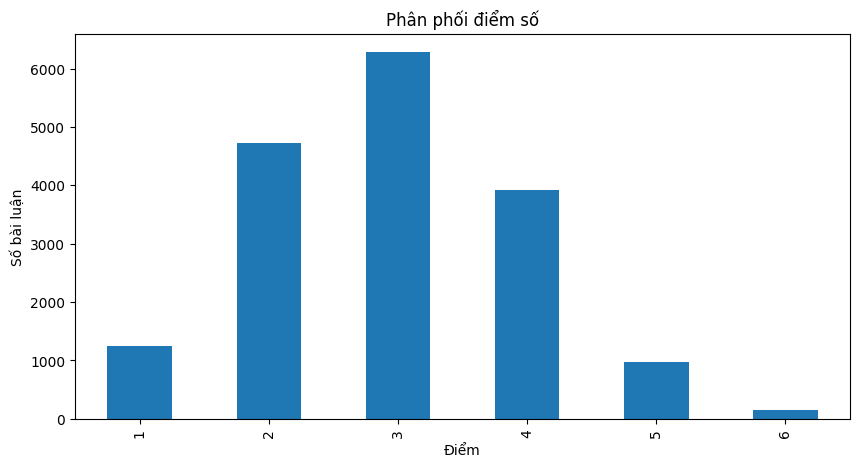

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
train_df['score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Điểm')
plt.ylabel('Số bài luận')
plt.title('Phân phối điểm số')
plt.show()


### Phân phối độ dài bài luận

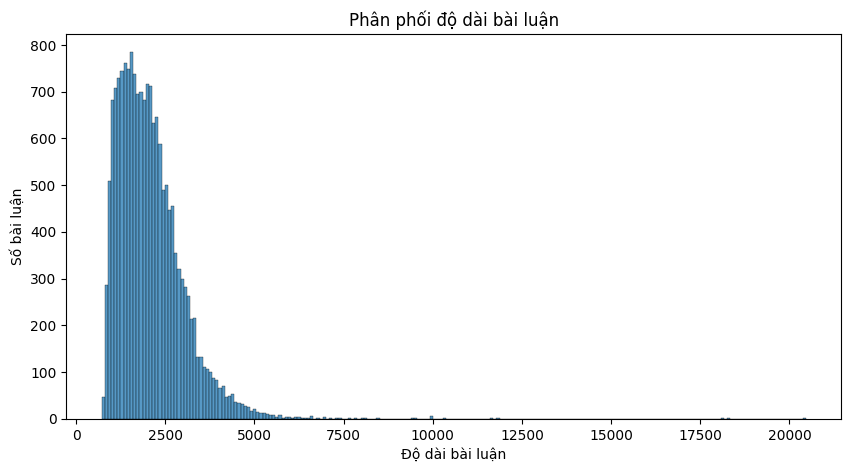

In [15]:
train_df_copy = train_df.copy()
train_df_copy['essay_length'] = train_df['full_text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(train_df_copy['essay_length'])
plt.title('Phân phối độ dài bài luận')
plt.xlabel('Độ dài bài luận')
plt.ylabel('Số bài luận')
plt.show()

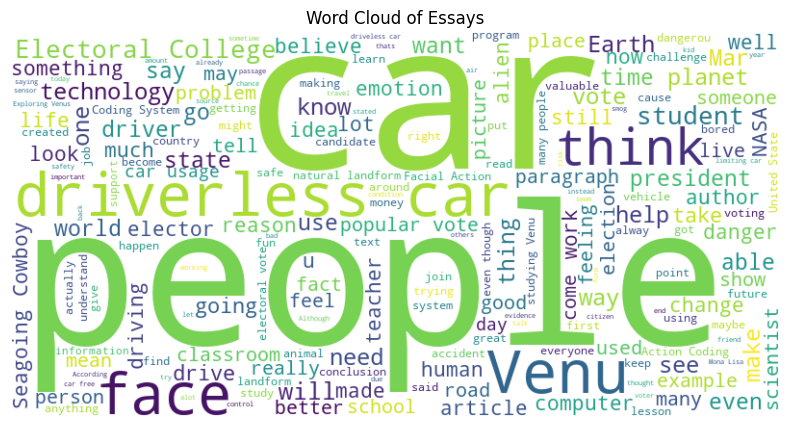

In [21]:
from wordcloud import WordCloud

all_essays = ' '.join(train_df['full_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_essays)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Essays')
plt.axis('off')
plt.show()